<a id='section_id1'></a>
# BOM Weather

### A project evaluating the Persistence Model against the AUS Bureau of Meteorology.
We often get a 7 day weather forecast but don't often go back to see how accurate the predictions were for 7 days ago.
This project looks to explore how accurate the weather forecast is according to a what is known as the Persistence Model.
The Persistence Model hypothesis for the weather domain is that "The weather tomorrow will be the same as today",   
or in mathematical terms Weather(t+1) = Weather(t), (t being today, or time).

The forecasts are already known to be very accurate for t = 1,2 and 3, so for this project I will be looking at t+7.

The persistence model, also called the naïve predictor, is often used as a reference as it is a good ground estimation of other algorithms,   
and often used as a reference for determining the skill factor of a competing forecast model.   

[Click Here for EDA Notebook](eda.ipynb#section_id1)

In [1]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
import datetime as dt

### DATA Sources 
- Data Comes From: ftp://ftp.bom.gov.au/anon/gen/fwo/
- Melbourne Forecast File: ftp://ftp.bom.gov.au/anon/gen/fwo/IDV10450.xml

The url for the BOM API is:
https://api.weather.bom.gov.au/v1/locations/r1r143/forecasts/daily   
Be Aware that the update is adjusted every 10mins.

In [2]:
temps = pd.read_csv('../data/temps.csv',infer_datetime_format=True,index_col=0)

In [3]:
url = 'https://api.weather.bom.gov.au/v1/locations/r1r143/forecasts/daily'
response = requests.get(url)
weather_dict = response.json() # format as json
print(weather_dict.keys())
number_of_forecasts = len(weather_dict['data'])-1

dict_keys(['data', 'metadata'])


### Summary of new data
Latest observations taken from BOM

In [4]:
print(f"New forecasts:	{number_of_forecasts}")
print(f"Starting on:	{weather_dict['data'][1]['date'][0:10]}")
print(f"Ending on:	{weather_dict['data'][number_of_forecasts]['date'][0:10]}")
print(f"Today's Temp:		{weather_dict['data'][0]['temp_max']}")
print(f"Tomorrow's Temp:	{weather_dict['data'][1]['temp_max']}","\n")
print(f"Here's today's forecast: \n{weather_dict['data'][0]['extended_text']}")

New forecasts:	6
Starting on:	2020-10-06
Ending on:	2020-10-11
Today's Temp:		14
Tomorrow's Temp:	18 

Here's today's forecast: 
Cloudy. High (70%) chance of showers or drizzle, most likely early this morning and then in the afternoon or evening. Winds southerly 15 to 25 km/h turning west to southwesterly 15 to 20 km/h in the evening.


### Append new data to existing data

In [5]:
if number_of_forecasts == 6:
    roll_days = ['today+0','today+1','today+2','today+3','today+4','today+5','today+6']
    date = weather_dict['data'][0]['date'][:10] # make datetime later.
    temperatures = [weather_dict['data'][i]['temp_max'] for i in range(len(weather_dict['data']))]
    df = pd.DataFrame(None,columns=roll_days)
    df.loc[0] = pd.Series(temperatures, index=temps.columns[:len(temperatures)]) # This series will not throw an error if len(data) is less than temps.
    df.index = [date]
    print(df.head(1),'\n')
    if date != temps.index[-1]:
        print(f'File not saved. Date already exists in index.')
    else:
        temps = temps.append(df)
        file_name = '../data/temps_' + str(date) + '.csv'
        temps.to_csv(file_name) # backup file.
        temps.to_csv('../data/temps.csv')
        print('File Saved')
else:
    print(f'Incorrect number of forecasts {number_of_forecasts}/6, please try again later.')

           today+0 today+1 today+2 today+3 today+4 today+5 today+6
2020-10-05      14      18      19      19      19      18      24 

File not saved. Date already exists in index.


#### Manually save to file not used at this point in time.

In [6]:
# temps.to_csv(file_name) # backup file.
# temps.to_csv('temps.csv')

Review New Data

In [7]:
temps.head(10)

,today+0,today+1,today+2,today+3,today+4,today+5,today+6
date,,,,,,,
2020-09-25,12,13,14,15,20,21,22
2020-09-26,13,14,15,21,19,20,24
2020-09-27,14,15,21,19,20,24,21
2020-09-28,15,21,19,20,27,28,16
2020-09-29,21,20,20,26,28,20,17
2020-09-30,19,20,26,27,17,17,17
2020-10-01,20,26,27,24,15,15,18
2020-10-02,27,28,25,14,15,18,20
2020-10-03,28,27,15,15,17,18,18


# PART 2: Plotting Data
- Load and plot weather forecasts.

In [8]:
# Seaborn lineplot, takes care of most settings.
import seaborn as sns

In [9]:
def plot_data(data,title):
    sns.set(rc={'figure.figsize':(12,5)})
    ax = sns.lineplot(data=data.T,legend=None, dashes=False,) # transpose df and dashes beyond 6 cols thows errors.
    ax.set_title(title, loc='center', fontsize=18)
    return plt.show();

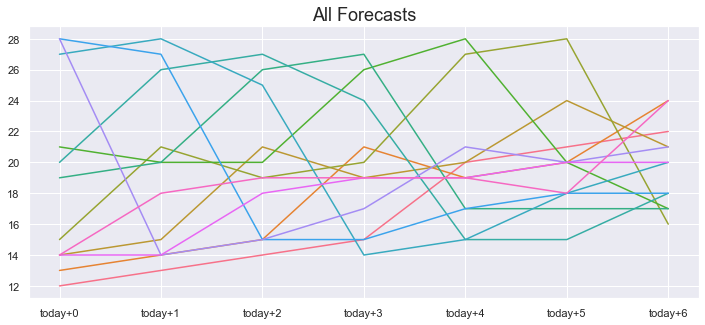

In [10]:
plot_data(temps,"All Forecasts")

The above chart shows a pattern, but isn't clealy interpretable.

In [11]:
def heat_map(data,title):
    fig, ax = plt.subplots(figsize = (10,10))
    ax = sns.heatmap(data, annot=True, center=True, cmap = 'coolwarm',cbar_kws={'label': 'Degrees Celcius'})
    ax.set_title(title, loc='center', fontsize=18)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    ax.figure.axes[-1].yaxis.label.set_size(14)
    ax.figure.axes[0].yaxis.label.set_size(14)
    ax.figure.axes[0].xaxis.label.set_size(14)
    return plt.show();

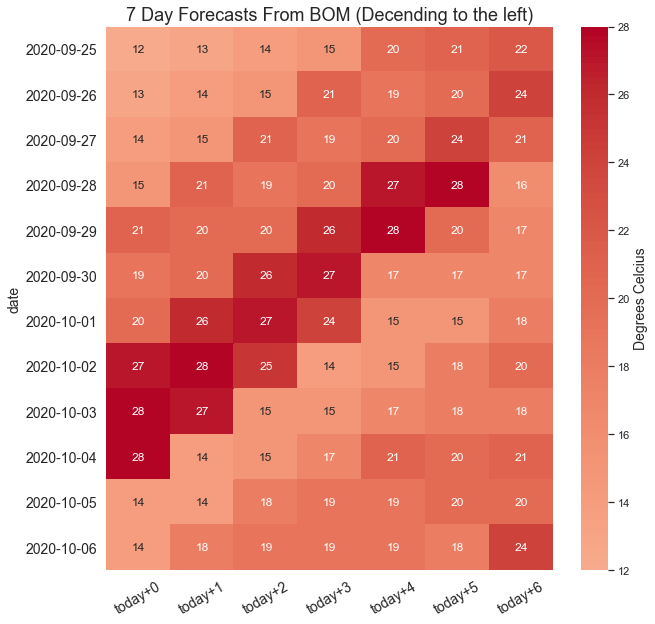

In [12]:
heat_map(temps,"7 Day Forecasts From BOM (Decending to the left)")

# PART 3: Build Evaluate Forecast Accuracy
- Check forecast against accuracy

In [13]:
basic_dates = temps.index # Keep non-datetime index list for charts. (avoid 00:00:00 ending)
temps.index = pd.to_datetime(temps.index) # make index a datetime.

def highlight_diags(data):
    '''Highlight Forecast Lines'''
    attr1 = 'background-color: lightgreen'
    attr2 = 'background-color: salmon'
    attr3 = 'background-color: lightblue'
    
    df_style = data.replace(data.values, '')
    np.fill_diagonal(np.flipud(df_style), attr1)
    np.fill_diagonal(np.flipud(df_style)[2:], attr2)
    np.fill_diagonal(np.flipud(df_style)[4:], attr3)
    return df_style

temps.style.apply(highlight_diags, axis=None)

,today+0,today+1,today+2,today+3,today+4,today+5,today+6
date,,,,,,,
2020-09-25 00:00:00,12,13,14,15,20,21,22
2020-09-26 00:00:00,13,14,15,21,19,20,24
2020-09-27 00:00:00,14,15,21,19,20,24,21
2020-09-28 00:00:00,15,21,19,20,27,28,16
2020-09-29 00:00:00,21,20,20,26,28,20,17
2020-09-30 00:00:00,19,20,26,27,17,17,17
2020-10-01 00:00:00,20,26,27,24,15,15,18
2020-10-02 00:00:00,27,28,25,14,15,18,20
2020-10-03 00:00:00,28,27,15,15,17,18,18


The date being forecast shifts down and to the left as the date approaches.   
Note, the highlighting does not appear on GitHub. Please view file locally.

In [14]:
# Acuracy Mechanism: Compare forecast to actual Temp.
fac = pd.DataFrame()
counter = list(range(len(temps)))
columns = list(temps.columns)

for i in counter:
    # 7 day forecast inc today, so len can't exceed 7
    if i < 7:
        window = i 
        j = i
    else: 
        window = 6
        j = 6
    
    # Start date at most recent row
    actual_date = temps.index[-1] # start with the last day
    window_date = actual_date - pd.DateOffset(days=window) # Number of days in the past can't be more than those forecast
    row_0 = temps.index[0] # We want to end when window date is equal to row_0.
    
    temps_list = [] # temporary holder of weeeks values.
    while window_date >= row_0:
        true_temp = int(temps.loc[actual_date][0]) # True temperature recorded on day
        predicted_temp = int(temps.loc[window_date][window]) # data predicted on value of window
        difference =  true_temp - predicted_temp
        # loop 
        actual_date -= pd.DateOffset(days=1) # take off 1 day.
        window_date -= pd.DateOffset(days=1) # take off 1 day.
        # append
        temps_list.append(difference)    
    # Add list to df as series    
    fac[columns[j]] = pd.Series(temps_list[::-1]) # Add list backwards.
        
fac.index = basic_dates
fac, temps

(            today+0  today+1  today+2  today+3  today+4  today+5  today+6
 date                                                                     
 2020-09-25        0      0.0      0.0      0.0      1.0     -2.0     -2.0
 2020-09-26        0      0.0      0.0      0.0      0.0      0.0      3.0
 2020-09-27        0      0.0      0.0      0.0      0.0      3.0      7.0
 2020-09-28        0      0.0      0.0      0.0      0.0      0.0     12.0
 2020-09-29        0     -1.0      0.0      1.0      0.0      8.0     -3.0
 2020-09-30        0      0.0      1.0      1.0     11.0     -3.0     -3.0
 2020-10-01        0      1.0      1.0      4.0     -1.0     -1.0      NaN
 2020-10-02        0      0.0      3.0      0.0     -1.0      NaN      NaN
 2020-10-03        0      1.0     -1.0     -1.0      NaN      NaN      NaN
 2020-10-04        0      0.0     -1.0      NaN      NaN      NaN      NaN
 2020-10-05        0      0.0      NaN      NaN      NaN      NaN      NaN
 2020-10-06        0     

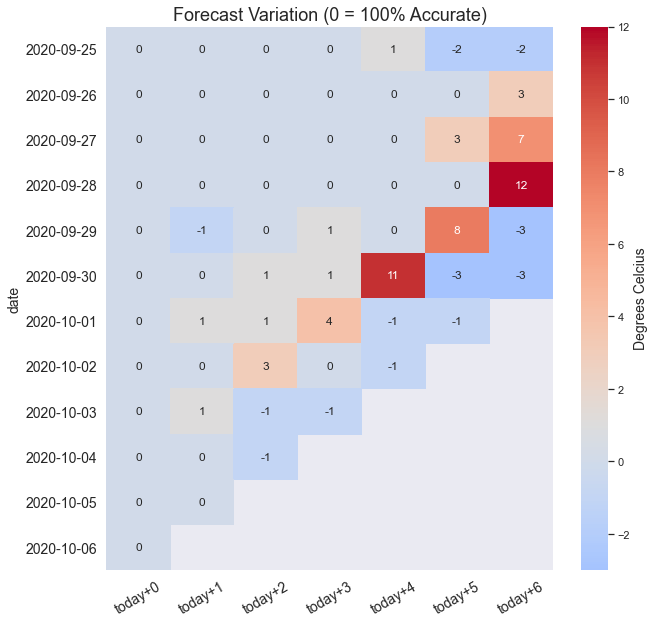

In [15]:
heat_map(fac,"Forecast Variation (0 = 100% Accurate)")

# PART 4: Build Persistence Model
- Build models for  Weather(t+i) = Weather(t)

In [16]:
# Persistance Mechanism
actual_date = temps.index[-1] # # Start date at most recent row
persistence_date = actual_date - pd.DateOffset(days=1) # The Day Earlier
row_0 = temps.index[0] # We want to end when window date is equal to row_0.

pmodel = []
while persistence_date >= row_0:
    actual_temp = temps.loc[actual_date][0]
    persistence_temp = temps.loc[persistence_date][0] # True temperature recorded on day before        
    pval = persistence_temp - actual_temp
    # loop 
    persistence_date -= pd.DateOffset(days=1)
    actual_date -= pd.DateOffset(days=1) # take off 1 day.
    # append
    pmodel.append(pval)
pmodel = pd.Series(pmodel[::-1])
print(list(temps['today+0'].values),"\n",list(pmodel))

[12, 13, 14, 15, 21, 19, 20, 27, 28, 28, 14, 14] 
 [-1, -1, -1, -6, 2, -1, -7, -1, 0, 14, 0]


Verify the persistance model we have is correct

# PART 5: Compare the two models
- Compare Persistance to the forecasts provided by the BOM

In [17]:
persistence = pd.DataFrame()
persistence['Persistence Accuracy'] = pmodel
for i in range(1,7):
    persistence[str(i)+' Day Forecast'] = pd.Series(fac['today+'+str(i)].values)
persistence.index = basic_dates[:len(basic_dates)-1]
persistence

,Persistence Accuracy,1 Day Forecast,2 Day Forecast,3 Day Forecast,4 Day Forecast,5 Day Forecast,6 Day Forecast
date,,,,,,,
2020-09-25,-1,0.0,0.0,0.0,1.0,-2.0,-2.0
2020-09-26,-1,0.0,0.0,0.0,0.0,0.0,3.0
2020-09-27,-1,0.0,0.0,0.0,0.0,3.0,7.0
2020-09-28,-6,0.0,0.0,0.0,0.0,0.0,12.0
2020-09-29,2,-1.0,0.0,1.0,0.0,8.0,-3.0
2020-09-30,-1,0.0,1.0,1.0,11.0,-3.0,-3.0
2020-10-01,-7,1.0,1.0,4.0,-1.0,-1.0,NaN
2020-10-02,-1,0.0,3.0,0.0,-1.0,NaN,NaN
2020-10-03,0,1.0,-1.0,-1.0,NaN,NaN,NaN


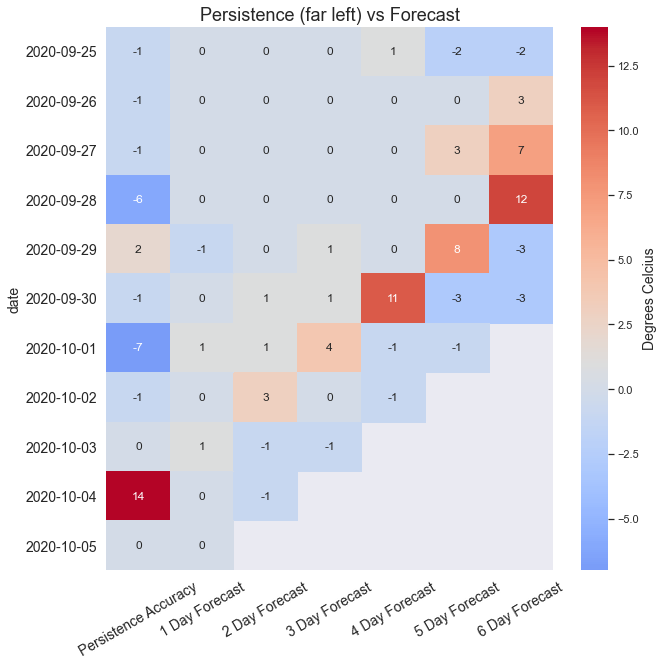

In [18]:
heat_map(persistence,"Persistence (far left) vs Forecast")

It appears that the persistance model may be a good benchmark for forecasts greater than 6 days away.   
To summarise, if you were to wager that the weather on a date 7 days from now,   
would be the closer to that of the day before rather than the BOM forecast, you would likely win.

# PART 6: Can we beat persistence?
- Using Facebook Prophet

### Build forecast model
Facebook Prophet is a popular and simple timeseries forecsting tool.

In [19]:
from fbprophet import Prophet

### Forecast function
- fbprophet documentation can be found here: https://facebook.github.io/prophet/docs/quick_start.html# fbprophet documentation can be found here: https://facebook.github.io/prophet/docs/quick_start.html

In [20]:
# Create a timeseries
start_date = temps.index[0] # First data point
end_date = temps.index[-1] # Last data point.

Prophet needs Date and values columns (ds and y)

In [21]:
pdf = pd.DataFrame(None)
pdf['ds'] = pd.date_range(start=start_date, end=end_date) # Create our date column
pdf['y'] = pdf['ds'].map(temps['today+0']).astype(int)
pdf.head()

,ds,y
0,2020-09-25,12
1,2020-09-26,13
2,2020-09-27,14
3,2020-09-28,15
4,2020-09-29,21


### Observations
- Model is a simple regression model.
- Model could be improved if data was resampled and smoothed using a Savgol filter.

       y                  ds
0   12.0 2020-09-25 00:00:00
1   13.0 2020-09-25 06:00:00
2   13.0 2020-09-25 12:00:00
3   13.0 2020-09-25 18:00:00
4   13.0 2020-09-26 00:00:00
5   14.0 2020-09-26 06:00:00
6   14.0 2020-09-26 12:00:00
7   14.0 2020-09-26 18:00:00
8   14.0 2020-09-27 00:00:00
9   15.0 2020-09-27 06:00:00
10  15.0 2020-09-27 12:00:00
11  15.0 2020-09-27 18:00:00
12  15.0 2020-09-28 00:00:00
13  21.0 2020-09-28 06:00:00
14  21.0 2020-09-28 12:00:00
15  21.0 2020-09-28 18:00:00
16  21.0 2020-09-29 00:00:00
17  19.0 2020-09-29 06:00:00
18  19.0 2020-09-29 12:00:00
19  19.0 2020-09-29 18:00:00
20  19.0 2020-09-30 00:00:00
21  20.0 2020-09-30 06:00:00
22  20.0 2020-09-30 12:00:00
23  20.0 2020-09-30 18:00:00
24  20.0 2020-10-01 00:00:00
25  27.0 2020-10-01 06:00:00
26  27.0 2020-10-01 12:00:00
27  27.0 2020-10-01 18:00:00
28  27.0 2020-10-02 00:00:00
29  28.0 2020-10-02 06:00:00
30  28.0 2020-10-02 12:00:00
31  28.0 2020-10-02 18:00:00
32  28.0 2020-10-03 00:00:00
33  28.0 2020-

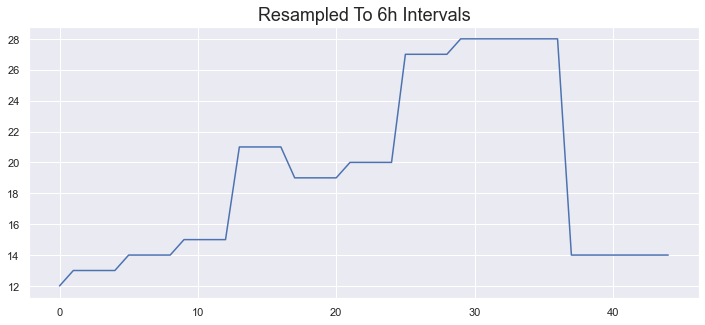

In [22]:
pdf.index = pd.to_datetime(pdf['ds'])
pdf = pdf.resample('6h').mean().bfill() # Resample dates to 6h intervals and back fill.
pdf['ds'] = pdf.index
pdf = pdf.reset_index(drop=True)
print(pdf)
plot_data(pdf['y'],"Resampled To 6h Intervals") # plot y

### Smoth Values
- SavGol filter is excellent for smoothing a timeseries signal

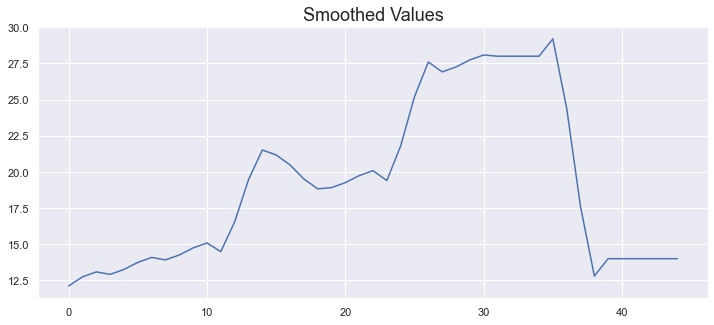

In [23]:
from scipy.signal import savgol_filter
# Smooth with SavGol filter
pdf_sg = pdf
savgol = [savgol_filter(pdf_sg[i], 5, 2, mode='interp') for i in pdf_sg] #'mirror', 'constant', 'nearest', 'wrap' or 'interp'
savgol = pd.DataFrame(savgol, columns=pd.to_datetime(pdf_sg.index), index=pdf_sg.columns)
savgol = savgol.T # Needed a flip
pdf['y'] = savgol['y']
plot_data(pdf['y'],"Smoothed Values") # plot y

## Use Facebook Prophet to forecast tomorrow's temperature
Facebook Prophet has the ability to detect cycles which may help make more accurate forecasts   
as more data is collected.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/Users/bfg.digital/Applications/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))



 The forecast suggested by Facebook Prophet is: 22 



,ds,yhat,yhat_lower,yhat_upper
45,2020-10-07,22.92512,16.201877,29.921588


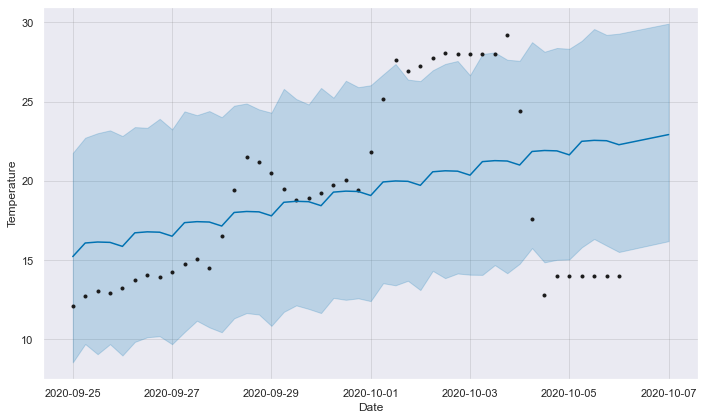

In [24]:
model = Prophet()
model.fit(pdf)
future = model.make_future_dataframe(periods = 1) # forecast 2 days beyond available data.
forecast = model.predict(future)
figure = model.plot(forecast, xlabel = 'Date', ylabel = 'Temperature')
print('\n',f"The forecast suggested by Facebook Prophet is: {int(forecast['yhat'][len(forecast)-1])}",'\n')
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1)  # show the dataframe.

Prophet has attempted to find cyclic patterns, but results are based on weak linear regression.

## New Forecast
Using cleaned BOM data from EDA

In [25]:
weather = pd.read_csv('../data/weather.csv',infer_datetime_format=True,index_col=0)
weather.tail()

,rainfall_mm,quality_rf,max_temp_c,quality_mt,uv_index
date,,,,,
2020-09-30,1.0,0.0,19.0,0.0,4.0
2020-10-01,2.0,0.0,20.0,0.0,6.0
2020-10-02,0.0,0.0,26.0,0.0,7.0
2020-10-03,0.0,0.0,29.0,0.0,6.0
2020-10-04,0.0,0.0,18.0,1.0,3.0


## Fetch today's rainfall, and uv_index from our API forecast

In [26]:
tomorrow_max = weather_dict['data'][1]['temp_max']
rain = weather_dict['data'][1]['rain']['amount']['max']# - weather_dict['data'][0]['rain']['amount']['min'] # Using Max instead of average
uv = weather_dict['data'][1]['uv']['max_index']
q_rf = 1 # assuming quality data
q_mt = 1 # assuming quality data

## Forecast Max Temp with Random Forrest Regressor

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
y = weather['max_temp_c']
X = weather.drop(['max_temp_c'], axis=1)

regr = RandomForestRegressor(max_depth=3, random_state=42)
regr.fit(X, y)

RandomForestRegressor(max_depth=3, random_state=42)

In [29]:
[predicted_mt] = regr.predict([[rain, q_rf, q_mt, uv]]) # sbracket both sides to remove from list.
score = regr.score(X, y) # R^2 (coefficient of determination) regression score function.
print(f'The temperature forecast by the BOM tomorrow is {tomorrow_max} and by our model is {predicted_mt:.2f}, with {score:.2f}% accuracy')

The temperature forecast by the BOM tomorrow is 18 and by our model is 20.84, with 0.40% accuracy


# Putting all the pieces together
Build a new forecast and add it to existing forecasts.

In [30]:
bens_vs_bom = pd.read_csv('../data/ben_vs_bom.csv',infer_datetime_format=True,index_col=0)

In [31]:
date = weather_dict['data'][0]['date'][:10] # We want it as a string, not a datetime.

# Forecasts
persistence_forecast = int(temps[::-1]['today+0'][0]) # Yesterday's temp
prophet_forecast = int(forecast['yhat'][len(forecast)-1::]) # Prophet temp
randomforest_forecast = predicted_mt # Random Forest temp
bens_forecast = (int(forecast['yhat'][len(forecast)-1::]) + int(temps[::-1]['today+0'][0]) + predicted_mt)/3 # Average of all three guesses.
BOM_forecast = tomorrow_max # BOM forecast

forecasts = [persistence_forecast, prophet_forecast, randomforest_forecast, bens_forecast, BOM_forecast]
final_set = pd.DataFrame(None,columns=bens_vs_bom.columns)
final_set.loc[0] = pd.Series(forecasts, index=bens_vs_bom.columns)
final_set.index = [date]

### So to wrap up, what do our models forecast the weather will be tomorrow?

In [32]:
final_set

,Persistence,Prophet,RandomForest,Bens Best Guess,BOM Forecast
2020-10-05,14.0,22.0,20.838297,18.946099,18.0


## Conclusion: Close! But get your weather forecast from the weather channel.

In [33]:
if date == bens_vs_bom.index[-1]:
    print(f'File not saved. Date already exists in index, but thanks for comming!')
else:
    bens_vs_bom = bens_vs_bom.append(df)
    bens_vs_bom.to_csv('../data/ben_vs_bom.csv') # backup file.
    print('File Saved, Thanks for coming.')

File not saved. Date already exists in index, but thanks for comming!
